In [9]:
import numpy as np
import util
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [5]:
trainfile = 'data/train.csv'
header, ids, X, Y = util.fetch_data(trainfile)

seed = 229
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# Basic Classifier
with data split into training and dev sets

In [ ]:
xgbreg = XGBRegressor(objective='binary:logistic', max_depth=7, learning_rate=0.1)

xgbreg.fit(X_train, y_train)

In [ ]:
# gini score for training data
print(util.gini_normalized(y_train, xgbreg.predict(X_train)))

In [ ]:
# gini score for dev data
print(util.gini_normalized(y_test, xgbreg.predict(X_test)))

In [ ]:
xgbreg.fit(X, Y) # retrain with all of data
util.make_prediction(xgbreg, 'data/test.csv', 'predictions/xgboost.csv')

In [ ]:
trainsizes, traingini, testgini = util.learning_curves(xgbreg, X_train, X_test, y_train, y_test)
print(traingini)
print('')
print(testgini)
plt.figure()
plt.plot(trainsizes, traingini, label='train gini')
plt.plot(trainsizes, testgini, label='test gini')
plt.xlabel('Training set size')
plt.ylabel('Normalized Gini coefficient')
plt.title('XGBoost')
plt.legend()
plt.savefig('figures/learning_curves/xgboost.eps', format='eps', dpi=1000)

# Grid Search
with full data set and 3-fold CV

In [7]:
params_to_try = {'max_depth': range(1, 10), 'learning_rate':[0.05, 0.1, 0.2, 0.3]}
c_validator = GridSearchCV(xgbreg, params_to_try, scoring=util.gini_scorer, verbose=2, cv=3, n_jobs=-1)
c_validator.fit(X_train, y_train)


In [ ]:
print(util.gini_normalized(y_train, c_validator.predict(X_train))) # training score
print(util.gini_normalized(y_test, c_validator.predict(X_test)))   # test score

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def plot_gridsearch_3d(c_validator, param1, param2, param1name, param2name):
    cv_results = c_validator.cv_results_
    test_mean = cv_results['mean_test_score']
    train_mean = cv_results['mean_train_score']
    
    x = np.tile(param2, len(param1))
    y = np.repeat(param1, len(param2))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.scatter(x, y, test_mean)
    ax1.title("Grid Search Test Scores")
    ax1.xlabel(param2name)
    ax1.ylabel(param1name)
    
    ax2 = fig.add_subplot(111, projection='3d')
    ax2.scatter(x, y, train_mean)
    ax2.title("Grid Search Training Scores")
    ax2.xlabel(param2name)
    ax2.ylabel(param1name)
    fig.show()

In [10]:
def plot_gridsearch_2d(c_validator, param1, param2, param1name, param2name):
    cv_results = c_validator.cv_results_
    test_mean = cv_results['mean_test_score']
    train_mean = cv_results['mean_train_score']
    
    test_mean = np.array(test_mean).reshape(len(param1), len(param2))
    train_mean = np.array(train_mean).reshape(len(param1), len(param2))
    
    # Param2 is the X-axis, Param1 is represented as a different curve (color line)
    for idx, val in enumerate(param1):
        plt.plot(param2, test_mean[idx,:], '-o', label= param1name + ': ' + str(val))
        plt.title('XGBoost Grid Search Test Scores')
        plt.xlabel(param2name)
        plt.legend()

    plt.show()
    plt.savefig('figures/gridsearch_testscores.eps')
    
    for idx, val in enumerate(param1):
        plt.plot(param2, train_mean[idx,:], '-o', label= param1name + ': ' + str(val))
        plt.title('XGBoost Grid Search Training Scores')
        plt.xlabel(param2name)
        plt.legend()
    
    plt.show()
    plt.savefig('figures/gridsearch_trainscores.eps')

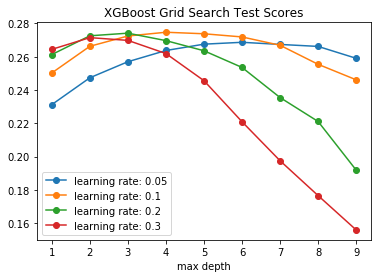

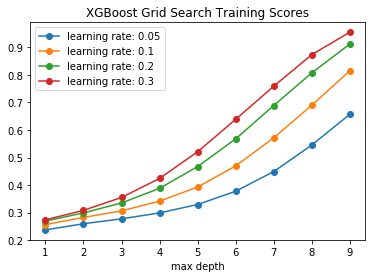

In [11]:
plot_gridsearch_2d(c_validator, params_to_try['learning_rate'], params_to_try['max_depth'], 'learning rate', 'max depth')

In [ ]:
c_validator.best_params_

In [3]:
import pickle

In [ ]:
pickle.dump(c_validator, open('models/xgbreg_gridsearch.pickle', 'wb'))

In [5]:
c_validator = pickle.load(open('models/xgbreg_gridsearch.pickle', 'rb'))

/Users/laurazhang/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Submission with model selected from grid search

In [ ]:
xgb_gridsearch = XGBRegressor(objective='binary:logistic', max_depth=4, learning_rate=0.1)
xgb_gridsearch.fit(X, Y)
pickle.dump(xgb_gridsearch, open('models/xgb_gridsearch1.pickle', 'wb'))

xgb_gridsearch = pickle.load(open('models/xgb_gridsearch1.pickle')).best_estimator_
print(xgb_gridsearch)

util.make_prediction(xgb_gridsearch, 'data/test.csv', 'predictions/xgboost_gridsearch1.csv',
                    predict_method = util.proba_method(xgb_gridsearch))